In [ ]:
import os, shutil, json
from sklearn.model_selection import train_test_split

# 1. Rename and copy raw image to nnUNet_raw folder

Train: 53 patients, Test: 22 patients

In [ ]:
raw_dir = "/media/storage/luu/BrainMRIReview/raw/MSLesSeg/train"
nnUNet_raw = "/media/storage/luu/nnUNet_raw/Dataset333_MSLesSeg"
nnUNet_raw_imagesTr = os.path.join(nnUNet_raw, "imagesTr")
nnUNet_raw_labelsTr = os.path.join(nnUNet_raw, "labelsTr")
nnUNet_raw_imagesTs = os.path.join(nnUNet_raw, "imagesTs")
nnUNet_raw_labelsTs = os.path.join(nnUNet_raw, "labelsTs")

In [3]:
patients = os.listdir(raw_dir)
train_patients, test_patients = train_test_split(patients, test_size=0.1, random_state=42)
n_train = len(train_patients)
n_test = len(test_patients)

print(f"{n_train} training patients, {n_test} testing patients.")
print(f"Testing patients: {test_patients}")

47 training patients, 6 testing patients.
Testing patients: ['P26', 'P47', 'P52', 'P2', 'P49', 'P13']


In [ ]:
channel_name_to_modality = {
    "1": "T1",
    "2": "T2",
    "3": "FLAIR"
}
modality_to_channel_name = {
    "T1": "1",
    "T2": "2",
    "FLAIR": "3"
}

def get_path_dict(patients, patient_dir, output_images_dir, output_labels_dir=None):
    path_dict = {}

    for patient in patients:
        path_dict[patient] = []
        patient_path = os.path.join(patient_dir, patient)
        timepoints = os.listdir(patient_path)
        for timepoint in timepoints:
            tp_path = os.path.join(patient_path, timepoint)
            images = os.listdir(tp_path)
            for image in images:
                # Create nnUNet_raw path
                image_id = image.replace(".nii.gz", "") # P26_T1_T1
                modality = image_id.split("_")[-1] # T1
                session_id = "_".join(image_id.split("_")[:-1]) # P26_T1

                if modality == "MASK":
                    new_image_id = session_id
                    if output_labels_dir is None:
                        raise ValueError("Missing dir for saving labels.")
                    new_image_path = os.path.join(output_labels_dir, f"{new_image_id}.nii.gz")
                else:
                    channel = modality_to_channel_name[modality]
                    new_image_id = f"{session_id}_000{channel}"
                    new_image_path = os.path.join(output_images_dir, f"{new_image_id}.nii.gz")
                
                # Original path
                original_image_path = os.path.join(tp_path, image)
                
                # Save a pair of original image path and nnUNet_raw image path
                path_dict[patient].append((original_image_path, new_image_path))
    
    return path_dict

# Copy training data
def save_path_dict_for_train():
    path_dict = get_path_dict(
        patients=train_patients,
        patient_dir=raw_dir,
        output_images_dir=nnUNet_raw_imagesTr,
        output_labels_dir=nnUNet_raw_labelsTr
    )

    output_path = os.path.join(nnUNet_raw, "path_dict_train.json")
    with open(output_path, "w") as f:
        json.dump(path_dict, f, indent=4)

    return path_dict

def save_path_dict_for_test():
    path_dict = get_path_dict(
        patients=test_patients,
        patient_dir=raw_dir,
        output_images_dir=nnUNet_raw_imagesTs,
        output_labels_dir=nnUNet_raw_labelsTs
    )

    output_path = os.path.join(nnUNet_raw, "path_dict_test.json")
    with open(output_path, "w") as f:
        json.dump(path_dict, f, indent=4)
        
    return path_dict

# Copy from original path to nnUNet_path
def copy_files(path_dict):
    
    current_patient = 0
    total_patient = len(path_dict)

    for patient, paths in path_dict.items():
        current_patient += 1
        print(f"[{current_patient}/{total_patient}] Copying patient {patient}...")
        
        for src, dst in paths:
            #print(src, dst)
            shutil.copyfile(src=src, dst=dst)


In [ ]:
# train_path_dict = save_path_dict_for_train()
# test_path_dict = save_path_dict_for_test()

# copy_files(train_path_dict)
# copy_files(test_path_dict)

# 2. Visualize prediction

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

In [14]:
model_name = "nnUNet"
prediction_dir = f"/media/storage/luu/SmallLesionMRI/MSLesSeg/{model_name}"
gt_images_dir = "/media/storage/luu/nnUNet_raw/Dataset333_MSLesSeg/imagesTs"
gt_labels_dir = "/media/storage/luu/nnUNet_raw/Dataset333_MSLesSeg/labelsTs"
metrics_csv = f"metrics/metrics_MSLesSeg_{model_name}.csv"

In [15]:
df = pd.read_csv(metrics_csv)
df

,sample,DICE,Hausdorff,Sensitivity,Specificity,True_volume,Predicted_volume
0,P13_T1.nii.gz,0.754983,7.810250,0.663429,0.999874,9.677,7.330
1,P13_T2.nii.gz,0.823734,2.000000,0.855181,0.999685,10.268,11.052
2,P26_T1.nii.gz,0.813862,8.185353,0.776472,0.999879,6.639,6.029
3,P2_T1.nii.gz,0.865361,1.414214,0.791685,0.999988,2.261,1.876
4,P2_T2.nii.gz,0.775844,26.153394,0.692027,0.999958,3.286,2.576
5,P2_T3.nii.gz,0.816097,1.414214,0.773161,0.999956,2.623,2.347
6,P2_T4.nii.gz,0.802373,12.884099,0.874150,0.999876,2.940,3.466
7,P47_T1.nii.gz,0.836228,1.000000,0.903288,0.999331,18.736,21.741
8,P49_T1.nii.gz,0.854193,6.708204,0.774813,0.999810,34.709,28.258
9,P49_T2.nii.gz,0.621702,5.830952,0.550947,0.999762,7.763,5.996


In [16]:
mean_dice = df["DICE"].mean()
mean_hd   = df["Hausdorff"].mean()
mean_sen  = df["Sensitivity"].mean()
mean_spe  = df["Specificity"].mean()

print(f"Mean Dice={mean_dice:.4f}\nMean HD={mean_hd:.4f}\nMean Sensitivity={mean_sen:.4f}\nMean Specificity={mean_spe:.4f}")

Mean Dice=0.7896
Mean HD=9.5907
Mean Sensitivity=0.7716
Mean Specificity=0.9998


In [17]:
sorted_df = df.sort_values(by="DICE", ascending=False)
sorted_df

,sample,DICE,Hausdorff,Sensitivity,Specificity,True_volume,Predicted_volume
3,P2_T1.nii.gz,0.865361,1.414214,0.791685,0.999988,2.261,1.876
8,P49_T1.nii.gz,0.854193,6.708204,0.774813,0.999810,34.709,28.258
7,P47_T1.nii.gz,0.836228,1.000000,0.903288,0.999331,18.736,21.741
1,P13_T2.nii.gz,0.823734,2.000000,0.855181,0.999685,10.268,11.052
10,P52_T1.nii.gz,0.818398,1.414214,0.831518,0.999908,3.306,3.412
5,P2_T3.nii.gz,0.816097,1.414214,0.773161,0.999956,2.623,2.347
2,P26_T1.nii.gz,0.813862,8.185353,0.776472,0.999879,6.639,6.029
6,P2_T4.nii.gz,0.802373,12.884099,0.874150,0.999876,2.940,3.466
4,P2_T2.nii.gz,0.775844,26.153394,0.692027,0.999958,3.286,2.576
0,P13_T1.nii.gz,0.754983,7.810250,0.663429,0.999874,9.677,7.330


Text(0.5, 0, 'Worst Case - P49_T2')

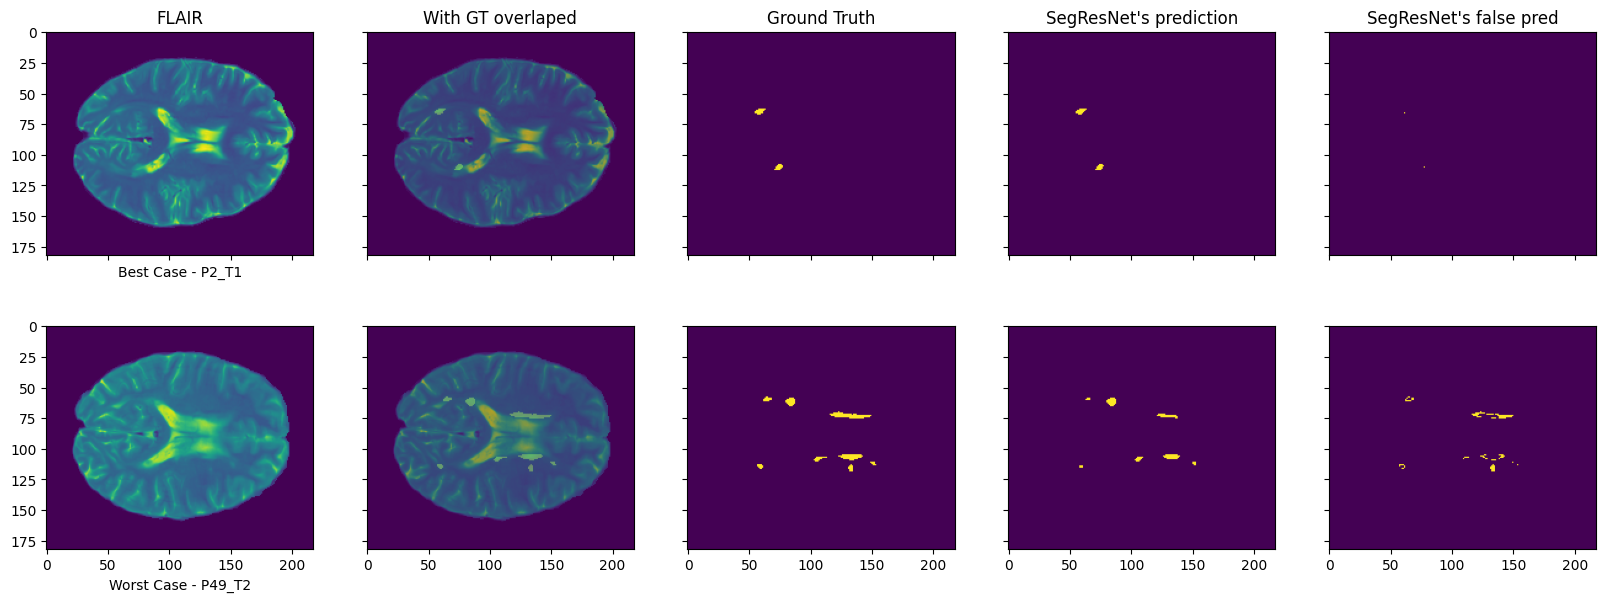

In [18]:
# Visualize best and worst case
slice_idx = 90
fig, axs = plt.subplots(2, 5, figsize=(20, 7), sharex=True, sharey=True)

# Set titles
axs[0,0].set_title("FLAIR")
axs[0,1].set_title("With GT overlaped")
axs[0,2].set_title("Ground Truth")
axs[0,3].set_title("SegResNet's prediction")
axs[0,4].set_title("SegResNet's false pred")


# Show best case
best_fn = sorted_df.iloc[0,0]
best_id = best_fn.replace(".nii.gz", "")
best_img = nib.load(os.path.join(gt_images_dir, f"{best_id}_0002.nii.gz")).get_fdata()
best_gt = nib.load(os.path.join(gt_labels_dir, best_fn)).get_fdata()
best_pred = nib.load(os.path.join(prediction_dir, best_fn)).get_fdata()
best_missed = np.abs(best_gt - best_pred)

axs[0,0].imshow(best_img[...,slice_idx])
axs[0,1].imshow(best_img[...,slice_idx])
axs[0,1].imshow(best_gt[...,slice_idx], alpha=0.3)
axs[0,2].imshow(best_gt[...,slice_idx])
axs[0,3].imshow(best_pred[..., slice_idx])
axs[0,4].imshow(best_missed[..., slice_idx])


# Show worst case
worst_fn = sorted_df.iloc[-1,0]
worst_id = worst_fn.replace(".nii.gz", "")
worst_img = nib.load(os.path.join(gt_images_dir, f"{worst_id}_0002.nii.gz")).get_fdata()
worst_gt = nib.load(os.path.join(gt_labels_dir, worst_fn)).get_fdata()
worst_pred = nib.load(os.path.join(prediction_dir, worst_fn)).get_fdata()
worst_missed = np.abs(worst_gt - worst_pred)

axs[1,0].imshow(worst_img[...,slice_idx])
axs[1,1].imshow(worst_img[...,slice_idx])
axs[1,1].imshow(worst_gt[...,slice_idx], alpha=0.3)
axs[1,2].imshow(worst_gt[...,slice_idx])
axs[1,3].imshow(worst_pred[..., slice_idx])
#axs[1,4].imshow(worst_pred[..., slice_idx])
axs[1,4].imshow(worst_missed[..., slice_idx])

# Show id of best and worst cases
axs[0,0].set_xlabel(f"Best Case - {best_id}")
axs[1,0].set_xlabel(f"Worst Case - {worst_id}")


<!-- # Notes:
1. What is the small lesions? (how much cm?) (*)
2. Compare predictions over timepoints of the same patient
3. Task: Identiy small lesions, classify small tumors, evaluate the size/volumne of the lesion
4. Dataset: MS, metastasis, maybe stroke. -->

In [7]:
# Visualize predictions of a patient with multiple timepoints
def plot_prediction_timepoints(patient_id, n_timepoints):
    slice_idx = 90
    fig, axs = plt.subplots(n_timepoints, 5, figsize=(20, n_timepoints*3), sharex=True, sharey=True)

    # Set titles
    axs[0,0].set_title("FLAIR")
    axs[0,1].set_title("With GT overlaped")
    axs[0,2].set_title("Ground Truth")
    axs[0,3].set_title("SegResNet's prediction")
    axs[0,4].set_title("SegResNet's false pred")

    # Set xlabels
    for j in range(n_timepoints):
        axs[j,0].set_xlabel(f"Timepoint {j+1}")


    for i in range(n_timepoints):
        sample_id = f"{patient_id}_T{i+1}"
        sample_fn = f"{sample_id}_0002.nii.gz"
        sample_img = nib.load(os.path.join(gt_images_dir, sample_fn)).get_fdata()
        sample_gt = nib.load(os.path.join(gt_labels_dir, f"{sample_id}.nii.gz")).get_fdata()
        sample_pred = nib.load(os.path.join(prediction_dir, f"{sample_id}.nii.gz")).get_fdata()
        sample_missed = np.abs(sample_gt - sample_pred)


        axs[i,0].imshow(best_img[...,slice_idx])
        axs[i,1].imshow(best_img[...,slice_idx])
        axs[i,1].imshow(best_gt[...,slice_idx], alpha=0.3)
        axs[i,2].imshow(best_gt[...,slice_idx])
        axs[i,3].imshow(best_pred[..., slice_idx])
        axs[i,4].imshow(best_missed[..., slice_idx])


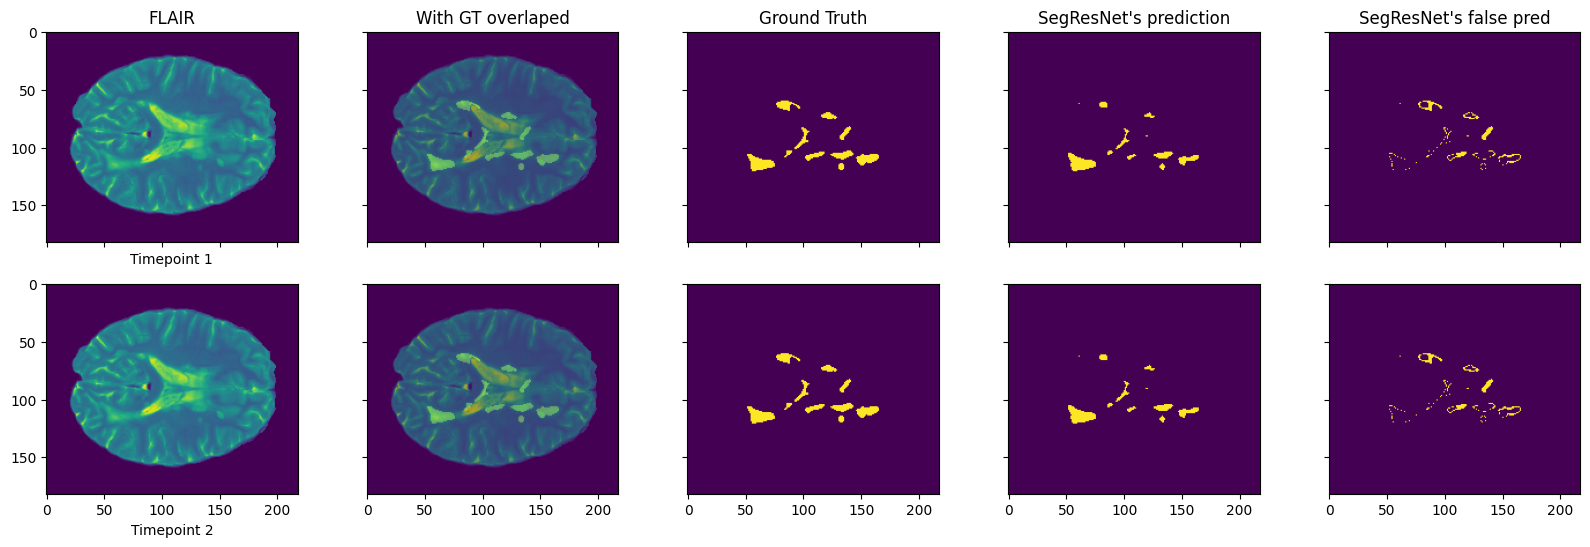

In [13]:
plot_prediction_timepoints(patient_id="P52", n_timepoints=2)

# 3. Compare metrics across models

In [3]:
import pandas as pd

In [4]:
nnUNet_csv = "metrics/metrics_MSLesSeg_nnUNet.csv"
unetr_csv = "metrics/metrics_MSLesSeg_UNETR.csv"
swin_csv = "metrics/metrics_MSLesSeg_SwinUNETR.csv"
segresnet_csv = "metrics/metrics_MSLesSeg_SegResNet.csv"
umbot_csv = "metrics/metrics_MSLesSeg_UMambaBot.csv"
umenc_csv = "metrics/metrics_MSLesSeg_UMambaEnc.csv"

nnUNet_df = pd.read_csv(nnUNet_csv)
unetr_df = pd.read_csv(unetr_csv)
swin_df = pd.read_csv(swin_csv)
segresnet_df = pd.read_csv(segresnet_csv)
umbot_df = pd.read_csv(umbot_csv)
umenc_df = pd.read_csv(umenc_csv)


In [5]:
def print_mean_metrics(csvs):
    for csv in csvs:
        ds_name = csv.split("_")[-1].replace(".csv", "")
        df = pd.read_csv(csv)
        mean_dice = df["DICE"].mean()
        mean_HD = df["Hausdorff"].mean()
        print(f"{ds_name}: Mean Dice={mean_dice:.4f}, Mean HD={mean_HD:.4f}")

print_mean_metrics([
    nnUNet_csv, segresnet_csv, unetr_csv, swin_csv, umbot_csv, umenc_csv
])

nnUNet: Mean Dice=0.7896, Mean HD=9.5907
SegResNet: Mean Dice=0.7697, Mean HD=14.1651
UNETR: Mean Dice=0.7474, Mean HD=23.2578
SwinUNETR: Mean Dice=0.7777, Mean HD=13.9264
UMambaBot: Mean Dice=0.7851, Mean HD=10.4546
UMambaEnc: Mean Dice=0.7828, Mean HD=12.9222


/tmp/ipykernel_2532643/818479221.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(dice_data, labels=labels, showfliers=True)


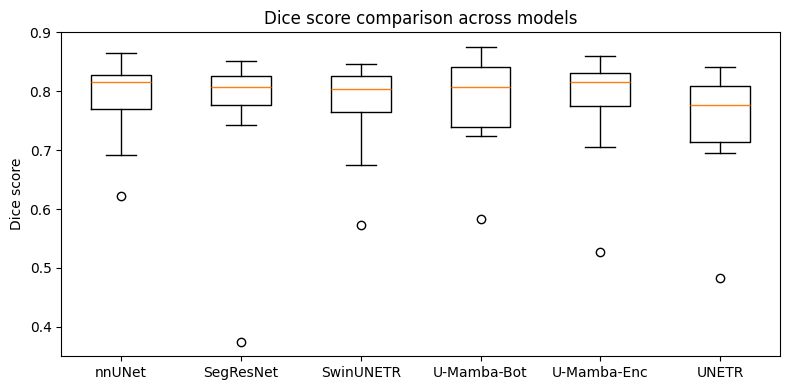

In [ ]:
# Compare models by Dice Score
files = {
    "nnUNet": "metrics/metrics_MSLesSeg_nnUNet.csv",
    "SegResNet": "metrics/metrics_MSLesSeg_SegResNet.csv",
    "SwinUNETR": "metrics/metrics_MSLesSeg_SwinUNETR.csv",
    "U-Mamba-Bot": "metrics/metrics_MSLesSeg_UMambaBot.csv",
    "U-Mamba-Enc": "metrics/metrics_MSLesSeg_UMambaEnc.csv",
    "UNETR": "metrics/metrics_MSLesSeg_UNETR.csv",
}

dice_data = []
labels = []

for model, path in files.items():
    df = pd.read_csv(path)
    dice_data.append(df["DICE"].values)
    labels.append(model)

# ---------------- Box plot ----------------
plt.figure(figsize=(8, 4))
plt.boxplot(dice_data, labels=labels, showfliers=True)
plt.ylabel("Dice score")
plt.title("Dice score comparison across models")
plt.tight_layout()
plt.show()

/tmp/ipykernel_2532643/4146372912.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(hd_data, labels=labels, showfliers=True)


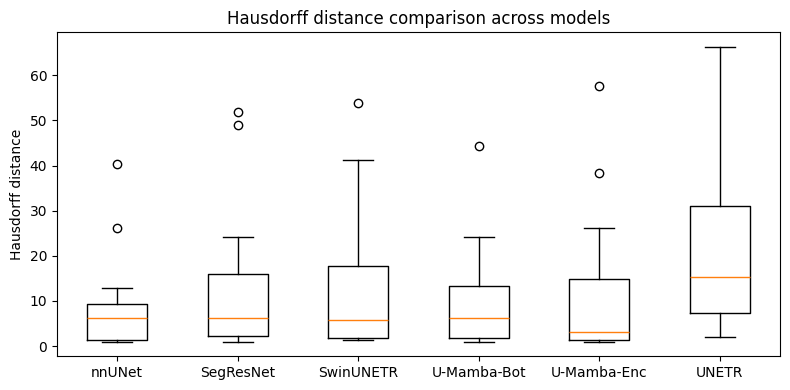

In [ ]:
# Compare HD distance (worst case mismatch)
hd_data = []
labels = []

for model, path in files.items():
    df = pd.read_csv(path)
    hd_data.append(df["Hausdorff"].values)
    labels.append(model)

# ---------------- Box plot ----------------
plt.figure(figsize=(8, 4))
plt.boxplot(hd_data, labels=labels, showfliers=True)
plt.ylabel("Hausdorff distance")
plt.title("Hausdorff distance comparison across models")
plt.tight_layout()
plt.show()

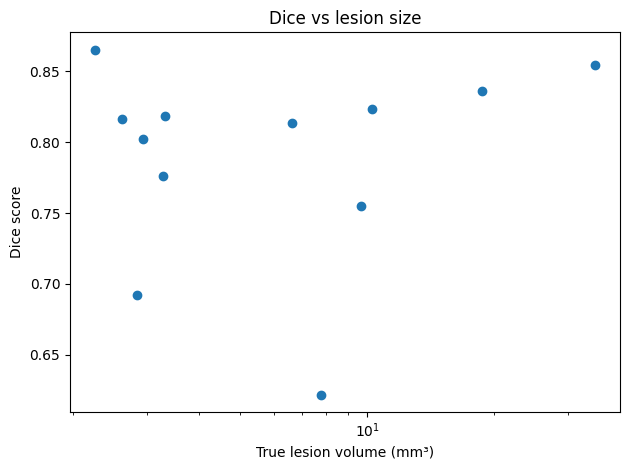

In [46]:
df = pd.read_csv("metrics/metrics_MSLesSeg_nnUNet.csv")

plt.figure()
plt.scatter(df["True_volume"], df["DICE"])
plt.xscale("log")
plt.xlabel("True lesion volume (mm³)")
plt.ylabel("Dice score")
plt.title("Dice vs lesion size")
plt.tight_layout()
plt.show()

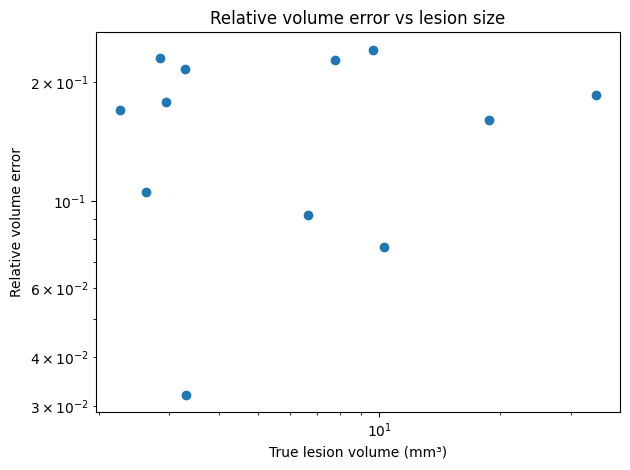

In [40]:
df["RVE"] = (
    (df["Predicted_volume"] - df["True_volume"]).abs()
    / df["True_volume"]
)

plt.figure()
plt.scatter(df["True_volume"], df["RVE"])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True lesion volume (mm³)")
plt.ylabel("Relative volume error")
plt.title("Relative volume error vs lesion size")
plt.tight_layout()
plt.show()

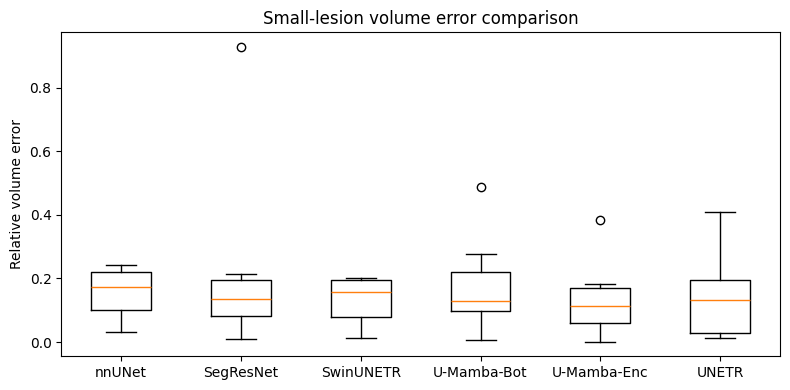

In [52]:
threshold = 3000  # mm³

rve_data = []
labels = []

for model, path in files.items():
    df = pd.read_csv(path)
    small = df[df["True_volume"] < threshold]
    rve = (
        (small["Predicted_volume"] - small["True_volume"]).abs()
        / small["True_volume"]
    )
    rve_data.append(rve.values)
    labels.append(model)

plt.figure(figsize=(8, 4))
plt.boxplot(rve_data, tick_labels=labels, showfliers=True)
plt.ylabel("Relative volume error")
plt.title("Small-lesion volume error comparison")
plt.tight_layout()
plt.show()

In [42]:
# Worst DICE cases of models
files = {
    "nnUNet": "metrics/metrics_MSLesSeg_nnUNet.csv",
    "SegResNet": "metrics/metrics_MSLesSeg_SegResNet.csv",
    "SwinUNETR": "metrics/metrics_MSLesSeg_SwinUNETR.csv",
    "UMambaBot": "metrics/metrics_MSLesSeg_UMambaBot.csv",
    "UMambaEnc": "metrics/metrics_MSLesSeg_UMambaEnc.csv",
    "UNETR": "metrics/metrics_MSLesSeg_UNETR.csv",
}

worst = {}

for model_name, csv_path in files.items():
    df = pd.read_csv(csv_path)
    sorted_df = df.sort_values(by="DICE").reset_index() 
    worst_case = sorted_df.loc[0, "sample"]
    worst_dice = sorted_df.loc[0, "DICE"]
    worst[model_name] = {
        "sample": worst_case,
        "worst_dice": worst_dice,
        "path": f"/media/storage/luu/SmallLesionMRI/MSLesSeg/{model_name}/{worst_case}"
    }

worst
    

{'nnUNet': {'sample': 'P49_T2.nii.gz',
  'worst_dice': np.float64(0.6217021585871066),
  'path': '/media/storage/luu/SmallLesionMRI/MSLesSeg/nnUNet/P49_T2.nii.gz'},
 'SegResNet': {'sample': 'P49_T2.nii.gz',
  'worst_dice': np.float64(0.3749889993839655),
  'path': '/media/storage/luu/SmallLesionMRI/MSLesSeg/SegResNet/P49_T2.nii.gz'},
 'SwinUNETR': {'sample': 'P49_T2.nii.gz',
  'worst_dice': np.float64(0.5722663233926911),
  'path': '/media/storage/luu/SmallLesionMRI/MSLesSeg/SwinUNETR/P49_T2.nii.gz'},
 'UMambaBot': {'sample': 'P49_T2.nii.gz',
  'worst_dice': np.float64(0.5824316264803613),
  'path': '/media/storage/luu/SmallLesionMRI/MSLesSeg/UMambaBot/P49_T2.nii.gz'},
 'UMambaEnc': {'sample': 'P49_T2.nii.gz',
  'worst_dice': np.float64(0.5278671643712189),
  'path': '/media/storage/luu/SmallLesionMRI/MSLesSeg/UMambaEnc/P49_T2.nii.gz'},
 'UNETR': {'sample': 'P49_T2.nii.gz',
  'worst_dice': np.float64(0.4820929641859284),
  'path': '/media/storage/luu/SmallLesionMRI/MSLesSeg/UNETR/P49_T

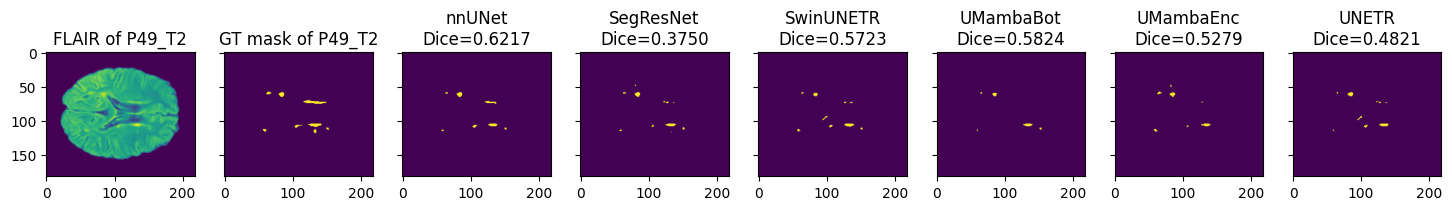

In [34]:
fig, axs = plt.subplots(1, 8, figsize=(18,5), sharex=True, sharey=True)

img_path = "/media/storage/luu/nnUNet_raw/Dataset333_MSLesSeg/imagesTs/P49_T2_0003.nii.gz"
img = nib.load(img_path).get_fdata()
axs[0].imshow(img[...,90])
axs[0].set_title(f"FLAIR of P49_T2")

img_path = "/media/storage/luu/nnUNet_raw/Dataset333_MSLesSeg/labelsTs/P49_T2.nii.gz"
img = nib.load(img_path).get_fdata()
axs[1].imshow(img[...,90])
axs[1].set_title(f"GT mask of P49_T2")

for i, (model_name, dict_) in enumerate(worst.items()):
    i += 2
    img_path = dict_["path"]
    img = nib.load(img_path).get_fdata()
    dice = dict_["worst_dice"]
    axs[i].imshow(img[...,90])
    axs[i].set_title(f"{model_name}\nDice={dice:.4f}")

In [43]:
best = {}

for model_name, csv_path in files.items():
    df = pd.read_csv(csv_path)
    sorted_df = df.sort_values(by="DICE", ascending=False).reset_index() 
    best_case = sorted_df.loc[0, "sample"]
    best_dice = sorted_df.loc[0, "DICE"]
    best[model_name] = {
        "sample": best_case,
        "worst_dice": best_dice,
        "path": f"/media/storage/luu/SmallLesionMRI/MSLesSeg/{model_name}/{worst_case}"
    }

best

{'nnUNet': {'sample': 'P2_T1.nii.gz',
  'worst_dice': np.float64(0.8653613729755861),
  'path': '/media/storage/luu/SmallLesionMRI/MSLesSeg/nnUNet/P49_T2.nii.gz'},
 'SegResNet': {'sample': 'P49_T1.nii.gz',
  'worst_dice': np.float64(0.8519622931896883),
  'path': '/media/storage/luu/SmallLesionMRI/MSLesSeg/SegResNet/P49_T2.nii.gz'},
 'SwinUNETR': {'sample': 'P2_T1.nii.gz',
  'worst_dice': np.float64(0.8460072018640119),
  'path': '/media/storage/luu/SmallLesionMRI/MSLesSeg/SwinUNETR/P49_T2.nii.gz'},
 'UMambaBot': {'sample': 'P2_T1.nii.gz',
  'worst_dice': np.float64(0.8750591575958353),
  'path': '/media/storage/luu/SmallLesionMRI/MSLesSeg/UMambaBot/P49_T2.nii.gz'},
 'UMambaEnc': {'sample': 'P49_T1.nii.gz',
  'worst_dice': np.float64(0.8599248108473723),
  'path': '/media/storage/luu/SmallLesionMRI/MSLesSeg/UMambaEnc/P49_T2.nii.gz'},
 'UNETR': {'sample': 'P47_T1.nii.gz',
  'worst_dice': np.float64(0.8420172750069658),
  'path': '/media/storage/luu/SmallLesionMRI/MSLesSeg/UNETR/P49_T2.n

## Next step:

For lesion-driven analysis:
- Relative volume Error = `abs(V_true - V_pred) / V_true` for all models
- FP (oversegment) and FN (missing lesions) for case-by-case
- Hard to detect lesions vs small lesions:

        - Small volume: < 3000 mm3
        - Lesion-to-background contrast (mean_lesion - mean_local_bg) / std_local_bg, low means low contrast
        - Boundary sharpness

- Compare metrics on groups of lesions (small-blurry, small-low sharpness boundary, etc.) -> which properties breaks which model
- Find ways to quantitatively separate lesions as differnt objects -> Lesion-wise recall vs size

Architecture-driven analysis:
- Get probabilities and compare -> max proba inside GT 
- Add blur and observe segmentation drop
- Feature extraction at a layer, then train a simple Logistic Regression -> classify bg and lesion

For new datasets: (lesions, tumors)
- Train on Everest for faster


## Issue:
- There is no `nvcc` in my container on Everest, but I cannot do `apt update` because I got blocked. Yakov is helping this.


# Notes:

1. Filter lesions < 1000 mm3 (=1cm diameter) (for one lesion)
2. How to measure shaprness of boundary? (1.5T -> 3T, quality of data are different) -> need to discuss with radiologists
3. Lesion contrast -> discuss with Margarita bc it's related to the radiomic features.